In [16]:
from os import path 

import anndata
import openTSNE
import scanpy as sc
import numpy as np
import pandas as pd

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [17]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "hochgerner_2018.h5ad"))
adata

AnnData object with n_obs × n_vars = 24185 × 27933 
    obs: 'labels', 'age'
    uns: 'name', 'organism', 'tissue', 'year'

In [18]:
adata.obs.head()

,labels,age
10X79_1_AAACTAGCTAGCCC-,neuroblast,P120
10X79_1_AAACTAGGATGTAT-,oligodendrocyte precursor cell,P120
10X79_1_AAACTCACGGCGTT-,granule cell,P120
10X79_1_AAACTGTCGGCTCA-,oligodendrocyte,P120
10X79_1_AAACTGTGATAAGT-,oligodendrocyte precursor cell,P120


In [19]:
colors = {
    # Excitatory neurons
    "immature pyramidal neuron": "#DE6093",
    "pyramidal neuron": "#D5221C",
    "immature granule cell": "#FEE00D",
    "juevnile granule cell": "#FAB508",
    "granule cell": "#FFA02C",
    # Inhibitory neurons
    "immature GABAergic neuron": "#74C9FF",
    "GABAergic neuron": "#68A8E6",
    "Cajal-Retzius cell": "#1C6865",
    # Neural progenitors
    "neuroblast": "#FEA388",
    "neuronal intermediate progenitor cells": "#FF7390",
    # Glia
    "ependymal cell": "#967D78",
    "oligodendrocyte precursor cell": "#9F9F9F",
    "newly formed oligodendrocyte": "#787878",
    "oligodendrocyte": "#505050",
    "immature astrocyte": "#9B7E7B",
    "juvenile astrocyte": "#846F57",
    "astrocyte": "#655C4A",
    "glial cell": "#7C9672",
    "radial glial cell": "#684644",
    
    "endothelial cell": "#5300FF",
    "vascular and leptomeningeal cell": "#8E97E4",
    "perivascular macrophage": "#8655F1",
}

## Preprocessing

In [20]:
sc.pp.filter_genes(adata, min_counts=10)
adata

AnnData object with n_obs × n_vars = 24185 × 17670 
    obs: 'labels', 'age'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.30
CPU times: user 1.5 s, sys: 848 ms, total: 2.34 s
Wall time: 2.34 s


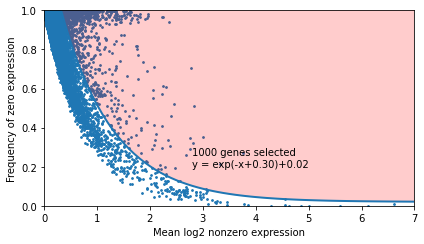

In [21]:
%time gene_mask = utils.select_genes(adata.X, n=1000, threshold=0)

In [22]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False)

In [23]:
adata.obsm["X_pca"] = x_pca = utils.pca(adata.X[:, gene_mask])

### Multiscale embedding

In [24]:
init = openTSNE.initialization.rescale(adata.obsm["X_pca"][:, :2])
affinities = openTSNE.affinity.Multiscale(
    adata.obsm["X_pca"],
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)
embedding = openTSNE.TSNE(
    initialization=init,
    n_jobs=8,
    random_state=0,
    verbose=True,
    affinities=affinities,
).fit(adata.obsm["X_pca"])

===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 24.59 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 17.99 seconds
--------------------------------------------------------------------------------
TSNE(affinities=<openTSNE.affinity.Multiscale object at 0x7f6a7ccf96d0>,
     initialization=array([[ 4.1094774e-04, -5.7259651e-05],
       [ 2.2777975e-04,  1.7932995e-04],
       [ 2.7671264e-04, -7.6406694e-05],
       ...,
       [ 3.5341948e-04, -1.1852314e-04],
       [ 4.4436660e-04, -1.3557584e-04],
       [ 3.5082892e-04, -4.1014413e-05]], dtype=float32),
     n_jobs=8, neighbors=None, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=2015.42 for 250 iterations...


/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Iteration   50, KL divergence 3.4490, 50 iterations in 5.5558 sec
Iteration  100, KL divergence 3.0788, 50 iterations in 5.4215 sec
Iteration  150, KL divergence 2.9910, 50 iterations in 5.5169 sec
Iteration  200, KL divergence 2.9541, 50 iterations in 5.6554 sec
Iteration  250, KL divergence 2.9348, 50 iterations in 5.4042 sec
   --> Time elapsed: 27.56 seconds
===> Running optimization with exaggeration=1.00, lr=2015.42 for 500 iterations...
Iteration   50, KL divergence 1.7704, 50 iterations in 5.3851 sec
Iteration  100, KL divergence 1.4511, 50 iterations in 5.4994 sec
Iteration  150, KL divergence 1.3126, 50 iterations in 5.6026 sec
Iteration  200, KL divergence 1.2360, 50 iterations in 5.5454 sec
Iteration  250, KL divergence 1.1885, 50 iterations in 5.7688 sec
Iteration  300, KL divergence 1.1572, 50 iterations in 5.9295 sec
Iteration  350, KL divergence 1.1354, 50 iterations in 6.6811 sec
Iteration  400, KL divergence 1.1199, 50 iterations in 6.3531 sec
Iteration  450, KL diver

In [25]:
adata.obsm["X_tsne"] = embedding.view(np.ndarray)

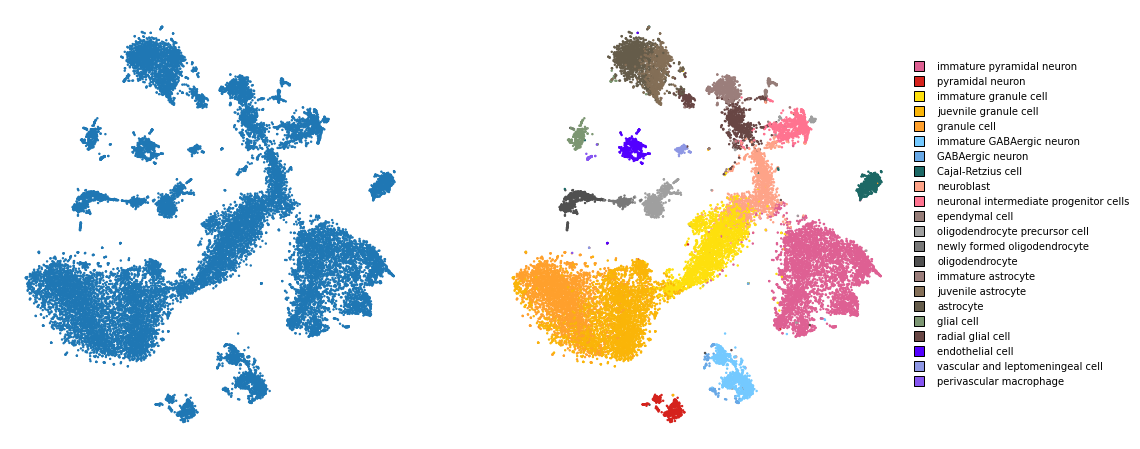

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names),
           s=2, alpha=1, draw_legend=False, ax=ax[0])
utils.plot(adata.obsm["X_tsne"], adata.obs["labels"].values,
           colors=colors, label_order=list(colors.keys()),
           s=2, alpha=1, draw_legend=True, ax=ax[1])

## Reload hochgerner

In [27]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "hochgerner_2018.h5ad"))
adata

AnnData object with n_obs × n_vars = 24185 × 27933 
    obs: 'labels', 'age'
    uns: 'name', 'organism', 'tissue', 'year'

In [28]:
adata.obsm["X_pca"] = x_pca
adata.obsm["X_tsne"] = embedding.view(np.ndarray)

## Load harris

In [36]:
new = anndata.read_h5ad(path.join("..", "data", "h5ad", "harris_2018.h5ad"))
new

AnnData object with n_obs × n_vars = 6971 × 27933 
    uns: 'name', 'organism', 'tissue', 'year'

## Align data sets

In [37]:
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_genes(new, min_counts=10)

In [38]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610011F06Rik', '0610012G03Rik',
       '0610030E20Rik', '0610037L13Rik',
       ...
       'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3',
       'mt-Nd4', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=15492)

In [39]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [40]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

Chosen offset: 0.27


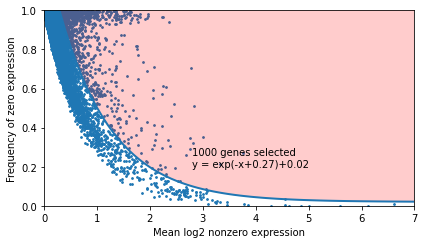

In [41]:
gene_mask = utils.select_genes(adata.X, n=1000, threshold=0)

In [42]:
adata_1000 = adata[:, gene_mask]
new_1000 = new[:, gene_mask]

## Find embeddings for new data

In [43]:
%%time
affinities = openTSNE.affinity.PerplexityBasedNN(
    adata_1000.X.toarray(),
    perplexity=30,
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)

===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 13.89 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.54 seconds
CPU times: user 50.3 s, sys: 1.16 s, total: 51.5 s
Wall time: 14.6 s


In [44]:
embedding = openTSNE.TSNEEmbedding(
    adata.obsm["X_tsne"],
    affinities,
    n_jobs=8,
    verbose=True,
)

In [45]:
%time new_embedding = embedding.transform(new_1000.X.toarray(), exaggeration=1.5)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 4.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 138359.1088, 50 iterations in 0.2287 sec
Iteration  100, KL divergence 138383.1957, 50 iterations in 0.1829 sec
Iteration  150, KL divergence 138419.1466, 50 iterations in 0.1831 sec
Iteration  200, KL divergence 138446.2630, 50 iterations in 0.1900 sec
Iteration  250, KL divergence 138472.4172, 50 iterations in 0.1823 sec
   --> Time elapsed: 0.97 seconds
CPU times: user 16.9 s, sys: 852 ms, total: 17.8 s
Wall time: 5.19 s


In [46]:
new.obsm["X_tsne"] = new_embedding.view(np.ndarray)

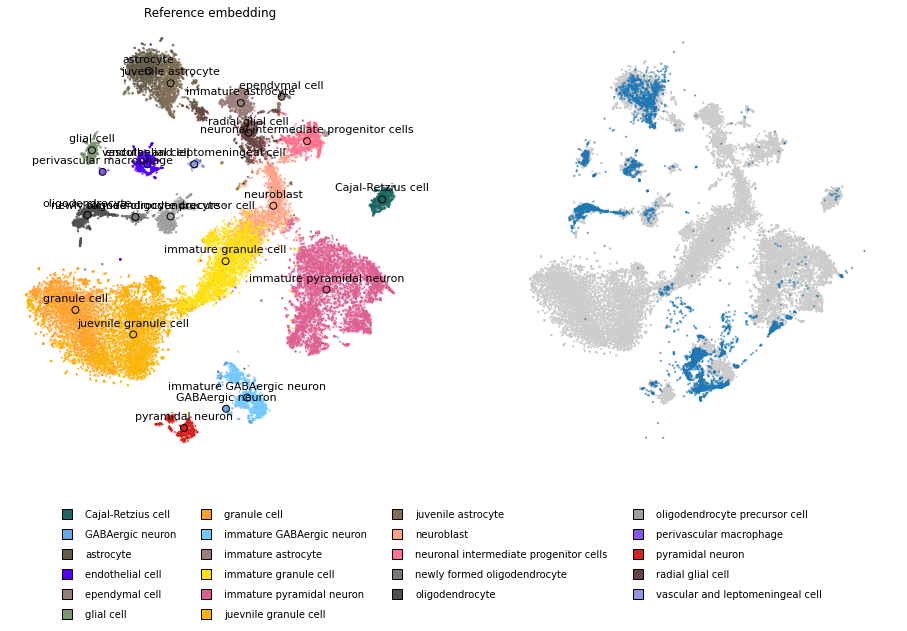

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

utils.plot(
    adata.obsm["X_tsne"], adata.obs["labels"], ax=ax[0], title="Reference embedding", s=2, colors=colors,
    draw_centers=True, draw_cluster_labels=True, fontsize=11,
    legend_kwargs=dict(
        loc="upper center", bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure,
        labelspacing=1, ncol=4
    )
)

colors_bw = {1: "#CCCCCC"}
utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax[1],
           colors=colors_bw, alpha=1, s=1, draw_legend=False)
utils.plot(new_embedding, np.ones_like(new_1000.obs.index), ax=ax[1],
           draw_legend=False, s=2, alpha=0.5, colors={1: "tab:blue"})
#ax[1].set_title("Transformed samples")

for ax_ in ax.ravel(): ax_.axis("equal")

## Examine markers

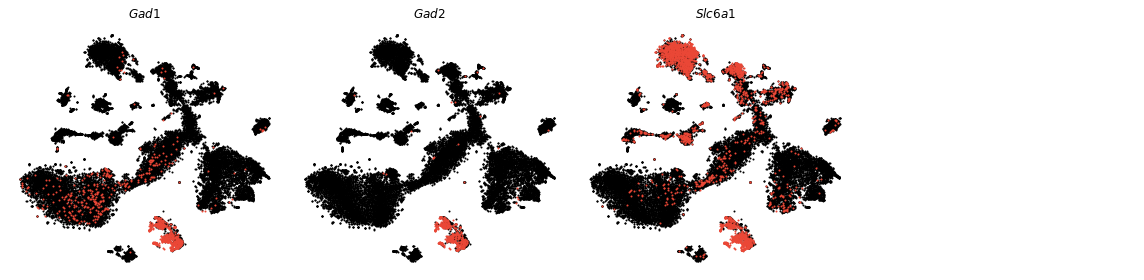

In [62]:
utils.plot_markers(["Gad1", "Gad2", "Slc6a1"], adata, adata.obsm["X_tsne"], alpha=1, threshold=1)

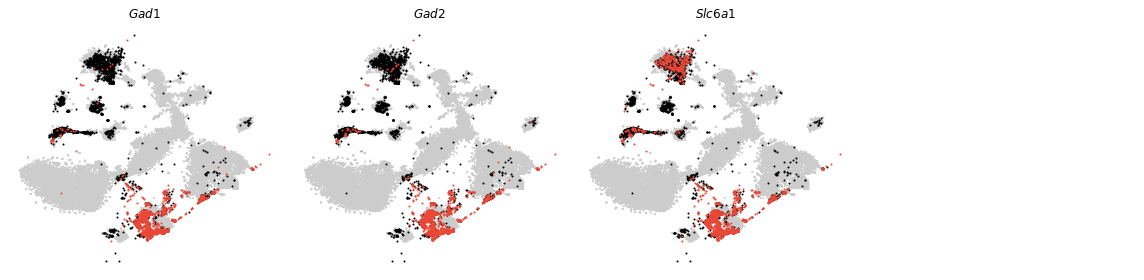

In [69]:
fig, ax = utils.plot_markers(["Gad1", "Gad2", "Slc6a1"], new, new.obsm["X_tsne"], alpha=1, threshold=1, zorder=2, return_ax=True)
for ax_ in ax.ravel()[:3]:
    colors_bw = {1: "#CCCCCC"}
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

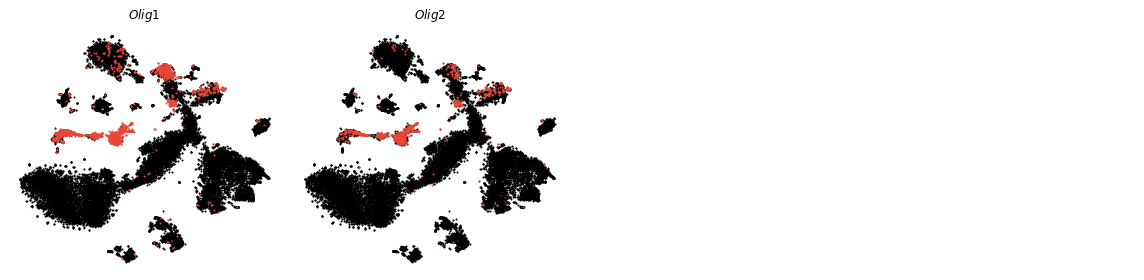

In [66]:
utils.plot_markers(["Olig1", "Olig2"], adata, adata.obsm["X_tsne"], alpha=1, threshold=1)

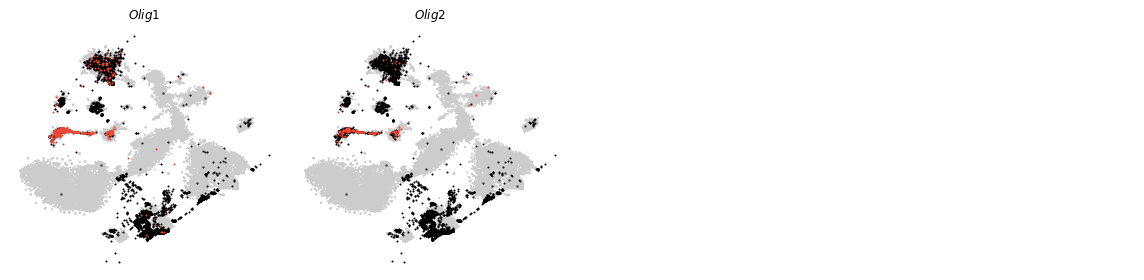

In [68]:
fig, ax = utils.plot_markers(["Olig1", "Olig2"], new, new.obsm["X_tsne"], alpha=1, threshold=1, zorder=2, return_ax=True)
for ax_ in ax.ravel()[:2]:
    colors_bw = {1: "#CCCCCC"}
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

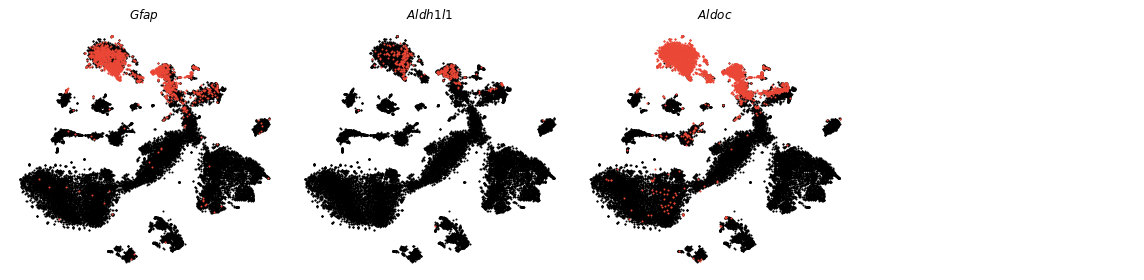

In [71]:
utils.plot_markers(["Gfap", "Aldh1l1", "Aldoc"], adata, adata.obsm["X_tsne"], alpha=1, threshold=1)

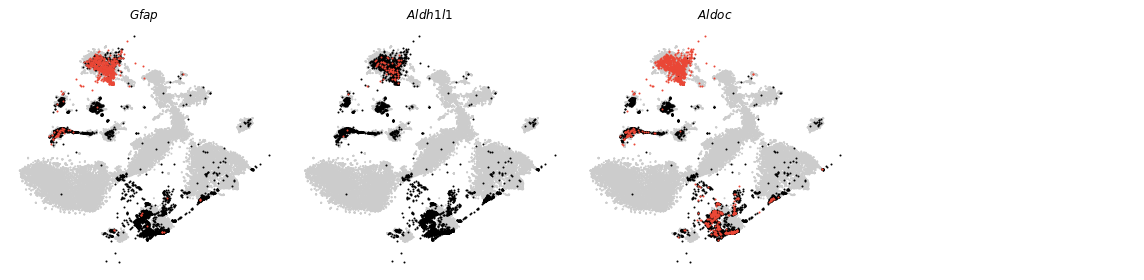

In [72]:
fig, ax = utils.plot_markers(["Gfap", "Aldh1l1", "Aldoc"], new, new.obsm["X_tsne"], alpha=1, threshold=1, zorder=2, return_ax=True)
for ax_ in ax.ravel()[:3]:
    colors_bw = {1: "#CCCCCC"}
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

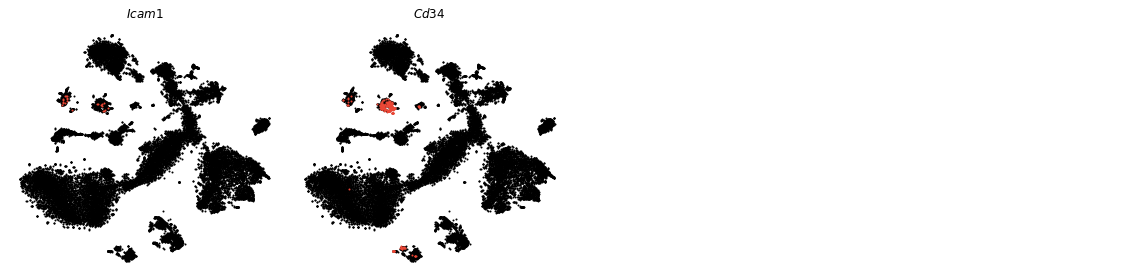

In [74]:
utils.plot_markers(["Icam1", "Cd34"], adata, adata.obsm["X_tsne"], alpha=1, threshold=1)

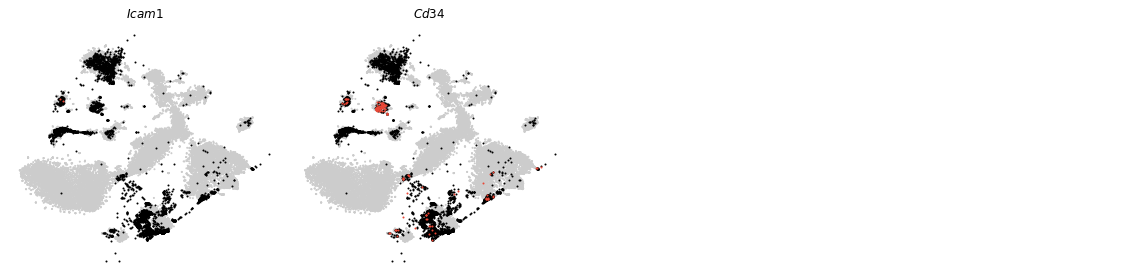

In [76]:
fig, ax = utils.plot_markers(["Icam1", "Cd34"], new, new.obsm["X_tsne"], alpha=1, threshold=1, zorder=2, return_ax=True)
for ax_ in ax.ravel()[:2]:
    colors_bw = {1: "#CCCCCC"}
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

## Final figure

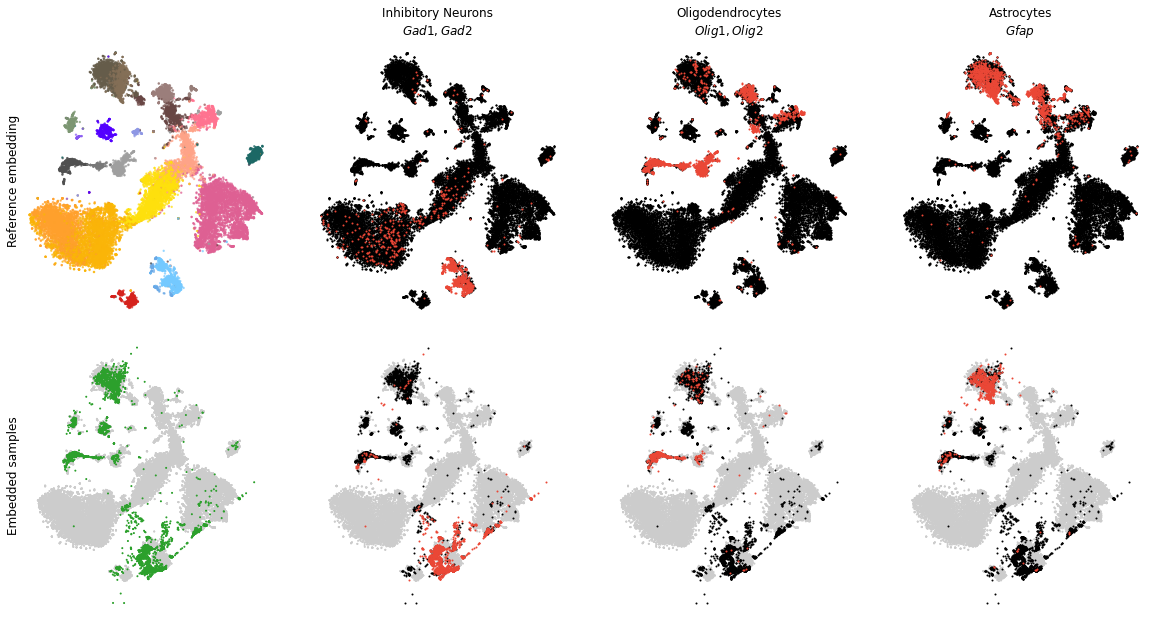

In [81]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))

ax[0, 0].text(-0, 0.5, "Reference embedding", transform=ax[0, 0].transAxes,
              rotation=90, verticalAlignment="center", size="large")
ax[1, 0].text(-0, 0.5, "Embedded samples", transform=ax[1, 0].transAxes,
              rotation=90, verticalAlignment="center", size="large")

utils.plot(
    adata.obsm["X_tsne"], adata.obs["labels"], ax=ax[0, 0], s=2, colors=colors,
    draw_centers=False, draw_cluster_labels=False, fontsize=11, draw_legend=False,
    legend_kwargs=dict(
        loc="upper center", bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure,
        labelspacing=1, ncol=4
    )
)

colors_bw = {1: "#CCCCCC"}
utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax[1, 0],
           colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)
utils.plot(new_embedding, np.ones_like(new_1000.obs.index), ax=ax[1, 0],
           draw_legend=False, s=1, alpha=1, colors={1: "tab:green"}, zorder=2)


# Plot reference silhouette onto bottom row
for ax_ in ax[1, :].ravel():
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

marker_params = dict(binary=True, alpha=1, threshold=1)
# Reference embeddings
utils.plot_marker(["Gad1", "Gad2"], adata, adata.obsm["X_tsne"], ax=ax[0, 1], **marker_params)
utils.plot_marker(["Olig1", "Olig2"], adata, adata.obsm["X_tsne"], ax=ax[0, 2], **marker_params)
utils.plot_marker(["Gfap"], adata, adata.obsm["X_tsne"], ax=ax[0, 3], **marker_params)
# Transformed embeddings
utils.plot_marker(["Gad1", "Gad2"], new, new.obsm["X_tsne"], ax=ax[1, 1], **marker_params)
utils.plot_marker(["Olig1", "Olig2"], new, new.obsm["X_tsne"], ax=ax[1, 2], **marker_params)
utils.plot_marker(["Gfap"], new, new.obsm["X_tsne"], ax=ax[1, 3], **marker_params)

ax[0, 1].set_title(f"Inhibitory Neurons\n{ax[0, 1].get_title()}")
ax[0, 2].set_title(f"Oligodendrocytes\n{ax[0, 2].get_title()}")
ax[0, 3].set_title(f"Astrocytes\n{ax[0, 3].get_title()}")

for ax_ in ax.ravel():
    ax_.set_xticks([]), ax_.set_yticks([])
    ax_.set_axis_off()
    ax_.axis("equal")
    
for ax_ in ax[1].ravel():
    ax_.set_title("")
    
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=1, bottom=0, left=0, right=1)

plt.savefig(path.join("..", "figures", "transform_hochgerner.pdf"), dpi=300, bbox_inches="tight", transparent=True, width=16, height=8)